# **Practice modeling and forecasting using GARCH**


## **Libraries and Basic Functions**



In [1]:
# Importing necessary libraries
!pip install -qq numpy==1.24.4
!pip install -qq pmdarima==2.0.3
!pip install -qq arch
!pip install -qq ta

from pmdarima.arima import auto_arima
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import kurtosis, skew
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.arima.model import ARIMA
from arch.unitroot import ADF, KPSS
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal
from arch.univariate.base import (
    ARCHModel,
    ARCHModelFixedResult,
    ARCHModelForecast,
    ARCHModelResult,
)
from tabulate import tabulate
from google.colab import files
import ta
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm  # Progress bar
import yfinance as yf

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
def plot_single_plot(data, ylabel, fig_title):
    """
    Plots a time series graph with improved formatting.

    Args:
        data: Pandas DataFrame with a Datetime or Period index and a single column.
        ylabel: Label for the y-axis.
        fig_title: Title of the plot.
    """
    # Convert PeriodIndex to DatetimeIndex if needed
    if isinstance(data.index, pd.PeriodIndex):
        data = data.copy()
        data.index = data.index.to_timestamp()

    # Set figure size
    plt.figure(figsize=(15, 6))

    # Plot the time series
    plt.plot(
        data.index,
        data,
        linestyle="-",
        linewidth=0.8
    )

    # Set labels and title
    plt.xlabel("Date")
    plt.ylabel(ylabel)
    plt.title(fig_title)

    # Format x-axis date labels for better readability
    plt.gcf().autofmt_xdate()
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))

    # Add grid
    plt.grid(True, linestyle="--", alpha=0.7)

    # Show the plot
    plt.tight_layout()
    plt.show()

def acf_plot(y, lags=20, figsize=(12, 6), style='bmh', title='ACF and PACF Plots'):
    """
    Plots ACF and PACF side-by-side for a given series.

    Parameters:
    - y: pandas Series or array-like
    - lags: Number of lags to use in ACF and PACF (default: 20)
    - figsize: Size of the figure (default: (12, 4))
    - style: Matplotlib style (default: 'bmh')
    - title: Title for the figure
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        fig.suptitle(title, fontsize=14)

        smt.graphics.plot_acf(y, lags=lags, ax=axes[0], alpha=0.05)
        axes[0].set_title("Autocorrelation (ACF)")

        smt.graphics.plot_pacf(y, lags=lags, ax=axes[1], alpha=0.05)
        axes[1].set_title("Partial Autocorrelation (PACF)")

        plt.tight_layout()  # Adjust layout to fit the title
        plt.show()

    return

def plot_histogram_qq(data, title_prefix=''):
    """
    Creates a subplot with a histogram and Q-Q plot for a given dataset.

    Args:
        data (array-like): The data to plot (e.g., residuals).
        title_prefix (str): Optional prefix for subplot titles.
    """
    plt.figure(figsize=(12, 6))

    # Histogram with KDE
    plt.subplot(1, 2, 1)
    sns.histplot(data, kde=True, bins=30, color='skyblue')
    plt.title(f'Histogram of{title_prefix}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True, linestyle='--', alpha=0.6)

    # Q-Q Plot
    plt.subplot(1, 2, 2)
    stats.probplot(data, dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of{title_prefix}')
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

def adf(data, trend='n', method='bic'):
  adf_result = ADF(data, trend=trend, method=method)  # Perform ADF test on the data
  print('Augmented Dickey-Fuller Unit Root Test:\n')  # Print test statistics and critical values
  return adf_result  # Return the result of the ADF test

def plot_bollinger_stoch(data, title_prefix='Fig', asset_name='Asset'):
    """
    Plots Bollinger Bands and Stochastic Oscillator on two subplots.

    Parameters:
    - data: pd.DataFrame with columns ['Close', 'bb_upper', 'bb_middle', 'bb_lower', 'stoch_k', 'stoch_d']
    - title_prefix: str, optional title prefix
    - asset_name: str, used in the plot title
    """
    if isinstance(data.index, pd.PeriodIndex):
        data.index = data.index.to_timestamp()

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    # --- Price + Bollinger Bands
    ax1.plot(data.index, data['Close'], label='Close Price', color='black')
    ax1.plot(data.index, data['bb_upper'], label='Upper Band', linestyle='--', color='red')
    ax1.plot(data.index, data['bb_middle'], label='Middle Band', color='blue')
    ax1.plot(data.index, data['bb_lower'], label='Lower Band', linestyle='--', color='green')
    ax1.fill_between(data.index, data['bb_lower'], data['bb_upper'], color='gray', alpha=0.1)
    ax1.set_title(f'{title_prefix}.1 - {asset_name} with Bollinger Bands')
    ax1.set_ylabel('Price')
    ax1.legend()
    ax1.grid(True)

    # --- Stochastic Oscillator
    ax2.plot(data.index, data['stoch_k'], label='%K', color='purple')
    ax2.plot(data.index, data['stoch_d'], label='%D', color='orange')
    ax2.axhline(80, color='red', linestyle='--', linewidth=1, label='Overbought')
    ax2.axhline(20, color='green', linestyle='--', linewidth=1, label='Oversold')
    ax2.set_title(f'{title_prefix}.2 - Stochastic Oscillator (3,3)')
    ax2.set_ylabel('Stochastic %')
    ax2.set_xlabel('Date')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


#  Function to format parameter with significance check
def format_param(param_name, params, pvals, sig_level=0.05):
    val = params.get(param_name, '-')
    pval = pvals.get(param_name, '-')

    if isinstance(val, float) and isinstance(pval, float):
        sig_marker = '*' if pval < sig_level else ''
        return f"{val:.4f}{sig_marker} ({pval:.4f})"
    else:
        return f"{val} ({pval})"

# Updated function to store results
def store_result(model_name, res):
    params = res.params
    pvals = res.pvalues
    aic = res.aic
    bic = res.bic
    log_lik = res.loglikelihood

    result = {
        'Model': model_name,
        'Constant': format_param('Const', params, pvals),  # 'Constant' for the mean model
        'Omega (ω)': format_param('omega', params, pvals),  # GARCH omega
        'Alpha (α)': format_param('alpha[1]', params, pvals),  # GARCH alpha[1]
        'Gamma (γ)': format_param('gamma[1]', params, pvals),  # GARCH gamma[1], if applicable
        'Beta (β)': format_param('beta[1]', params, pvals),  # GARCH beta[1]
        'Delta (δ)': format_param('delta', params, pvals),  # GARCH delta, if applicable
        'Eta (η)': format_param('eta', params, pvals),  # Skewed t-distribution eta
        'Lambda (λ)': format_param('lambda', params, pvals),  # Skewed t-distribution lambda
        'AIC': round(aic, 2),
        'BIC': round(bic, 2),
        'Log-Likelihood': round(log_lik, 2)
    }

    model_selection_result.append(result)

import requests

def download_csv(url, save_path='downloaded_file.csv'):
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad status codes

        with open(save_path, 'wb') as file:
            file.write(response.content)

        print(f"CSV file downloaded successfully and saved as '{save_path}'.")

    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")

def check_data(df, name: str):
    # Report missing values
    missing = df.isnull().sum().sum()
    print(f"\n{name} — Missing values: {missing}")

    # Drop missing
    df = df.dropna()

    # Confirm index and structure
    print(f"{name} — First date: {df.index[0]}, Last date: {df.index[-1]}, Freq: {df.index.freq}")
    return df

## **1. Data Pre-Processing**

### A. Download DOGE-USD data



In [3]:
# Download Doge-USD data
data = yf.download("DOGE-USD", start="2000-01-01", end="2025-04-30")
doge_usd = data["Close"].dropna()
doge_returns = doge_usd.pct_change().dropna()  # Convert to percentage returns
print(f'\n{doge_returns.head()}')
print(doge_returns.info())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Ticker      DOGE-USD
Date                
2017-11-10 -0.178092
2017-11-11  0.032674
2017-11-12 -0.135720
2017-11-13  0.166667
2017-11-14 -0.022296
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2728 entries, 2017-11-10 to 2025-04-29
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DOGE-USD  2728 non-null   float64
dtypes: float64(1)
memory usage: 42.6 KB
None


In [5]:
# Log Return
log_return = np.log(data["Close"] / data["Close"].shift(1)).dropna()
doge_rolling_7d = log_return.rolling(7).mean().dropna()
print(doge_rolling_7d.head())
print(doge_rolling_7d.info())

Ticker      DOGE-USD
Date                
2017-11-16 -0.002547
2017-11-17  0.017330
2017-11-18  0.019121
2017-11-19  0.040269
2017-11-20  0.020104
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2722 entries, 2017-11-16 to 2025-04-29
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DOGE-USD  2722 non-null   float64
dtypes: float64(1)
memory usage: 42.5 KB
None


### B. Visual analysis





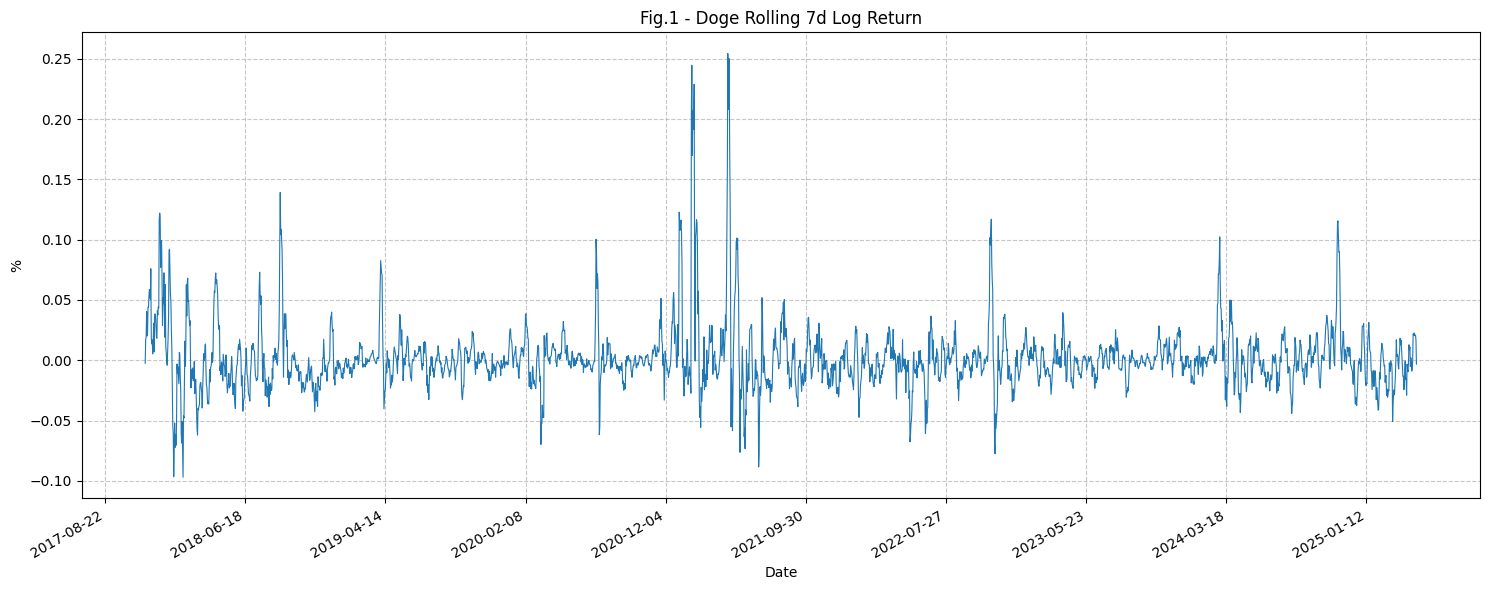

In [6]:
plot_single_plot(doge_rolling_7d, '%', 'Fig.1 - Doge Rolling 7d Log Return')

Fig.2 - Histogram and QQ-Plot of Doge Rollowing 7d Return


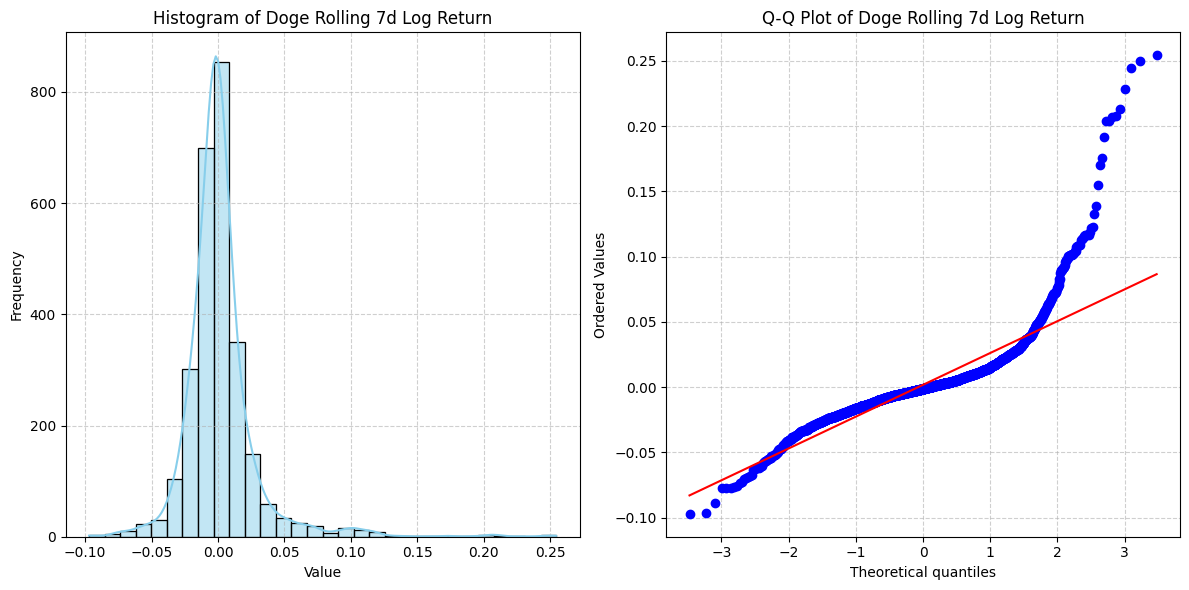

In [7]:
print('Fig.2 - Histogram and QQ-Plot of Doge Rollowing 7d Return')
plot_histogram_qq(doge_rolling_7d['DOGE-USD'], title_prefix=' Doge Rolling 7d Log Return')

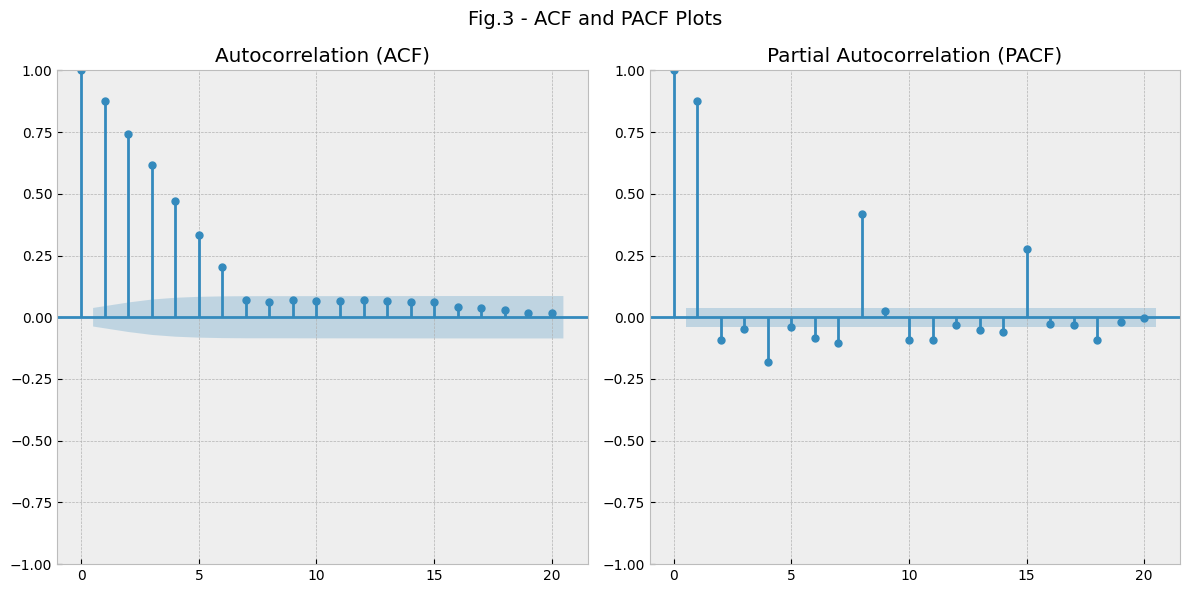

In [8]:
acf_plot(doge_rolling_7d['DOGE-USD'], lags=20, figsize=(12, 6), style='bmh', title='Fig.3 - ACF and PACF Plots')

### C. Descritptive Statistics

In [9]:
# Set target
target = doge_rolling_7d['DOGE-USD']

# Descriptive statistics
desc_stats = target.describe()
skew_val = skew(target)
kurtosis_val = kurtosis(target, fisher=True)  # Fisher's definition (normal=0)

# Create table with tabulate
headers = ['Statistic', 'Value']
data = [
    ['Mean', desc_stats.loc['mean']],
    ['Median', desc_stats.loc['50%']],  # or desc_stats.loc['50%']
    ['Maximum', desc_stats.loc['max']],
    ['Minimum', desc_stats.loc['min']],
    ['Std Dev', desc_stats.loc['std']],
    ['Skewness', skew_val],
    ['Kurtosis', kurtosis_val],
    ['Observations', int(desc_stats.loc['count'])]  # Convert to int
]

print("Table 1. Summary of Statistics for Doge Rolling 7d Log Return")
print(tabulate(data, headers=headers, tablefmt='fancy_grid', floatfmt=".4f"))

Table 1. Summary of Statistics for Doge Rolling 7d Log Return
╒══════════════╤═══════════╕
│ Statistic    │     Value │
╞══════════════╪═══════════╡
│ Mean         │    0.0018 │
├──────────────┼───────────┤
│ Median       │   -0.0012 │
├──────────────┼───────────┤
│ Maximum      │    0.2543 │
├──────────────┼───────────┤
│ Minimum      │   -0.0970 │
├──────────────┼───────────┤
│ Std Dev      │    0.0278 │
├──────────────┼───────────┤
│ Skewness     │    2.8902 │
├──────────────┼───────────┤
│ Kurtosis     │   18.1497 │
├──────────────┼───────────┤
│ Observations │ 2722.0000 │
╘══════════════╧═══════════╛


### D. Stationary Check

1. **Augmented Dickey-Fuller (ADF) Test**

* **Null Hypothesis (H₀)**: The series has a **unit root** → **non-stationary**
* **Alternative Hypothesis (H₁)**: The series is **stationary**
* **Decision Rule**:

  * Reject H₀ if:

    * Test Statistic < Critical Value (e.g., at 5% level), **and**
    * p-value < 0.05



In [10]:
# 1. Augmented Dickey-Fuller (ADF) Test
adf = ADF(target)
print(adf.summary().as_text())
print("\nConclusion:", "Stationary" if adf.pvalue < 0.05 and adf.stat < adf.critical_values['5%'] else "Non-stationary")

   Augmented Dickey-Fuller Results   
Test Statistic                 -7.720
P-value                         0.000
Lags                               28
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

Conclusion: Stationary


2. **ADF-GLS Test**

* **Same Hypotheses** and **decision rules** as ADF:

  * Reject H₀ if:

    * Test Statistic < Critical Value, and
    * p-value < 0.05



2. **KPSS Test**

* **Null Hypothesis (H₀)**: The series is **stationary**
* **Alternative Hypothesis (H₁)**: The series is **non-stationary**
* **Decision Rule**:

  * Reject H₀ (i.e., conclude **non-stationary**) if:

    * Test Statistic > Critical Value, or
    * p-value < 0.05


In [11]:
kpss = KPSS(target)
print(kpss.summary().as_text())

if kpss.pvalue >= 0.05 and kpss.stat < kpss.critical_values['5%']:
    conclusion = "Stationary (Fail to reject null hypothesis)"
else:
    conclusion = "Non-stationary (Reject null hypothesis)"

print("\nConclusion:", conclusion)

    KPSS Stationarity Test Results   
Test Statistic                  0.090
P-value                         0.639
Lags                               26
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.

Conclusion: Stationary (Fail to reject null hypothesis)


## E. ARCH effect



In [12]:
# Fit the auto_arima model
model_auto_selection = auto_arima(
    target,
    start_p = 0,
    start_d = 0,
    start_q = 0,
    max_p = 5,
    max_q = 5,
    information_criterion='aic',
    trace=True,
    with_intercept=False,
    return_valid_fits=True,
)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-11770.161, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-15725.726, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-13914.502, Time=0.65 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-15747.863, Time=0.50 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-15751.951, Time=0.41 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=-15840.284, Time=0.74 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=-15842.595, Time=0.84 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=-15843.731, Time=3.36 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=-15814.848, Time=0.55 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=-15846.309, Time=5.71 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=-16246.192, Time=3.49 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-15766.017, Time=2.57 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=-16227.485, Time=5.96 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-15744.152, Time=1.44 sec
 ARIM

In [13]:
# Fit the model with the optimal lag based on auto_arima
model_arima = ARIMA(target, order=(3, 0, 3), trend='n').fit()
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               DOGE-USD   No. Observations:                 2722
Model:                 ARIMA(3, 0, 3)   Log Likelihood                8136.539
Date:                Fri, 23 May 2025   AIC                         -16259.077
Time:                        04:04:22   BIC                         -16217.713
Sample:                    11-16-2017   HQIC                        -16244.125
                         - 04-29-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6945      0.015    111.812      0.000       1.665       1.724
ar.L2         -1.1991      0.026    -46.619      0.000      -1.249      -1.149
ar.L3          0.3425      0.014     24.505      0.000       0.315       0.370
ma.L1         -0.8607      0.016    -54.373      0.000      -0.892      -0.830
ma.L2          0.4777      0.020     23.841      0.000       0.438       0.517
ma.L3          0.3738      0.015     25.586      0.000       0.345       0.402
sigma2         0.0001   8.66e-07    170.249      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):            298912.68
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               0.56   Skew:                             3.23
Prob(H) (two-sided):                  0.00   Kurtosis:                        53.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Engle's ARCH test assesses:**

 - **Null hypothesis**: No ARCH effect (conditional homoscedasticity) — variance is constant over time.

 - **Alternative hypothesis**: ARCH effect present (conditional heteroscedasticity) — variance changes over time depending on past errors.

In [14]:
# Link to parameters: https://www.statsmodels.org/dev/_modules/statsmodels/stats/diagnostic.html#het_arch
lm_stat, lm_pvalue, f_stat, f_pvalue = het_arch(model_arima.resid, nlags=None, store=False, ddof=3)
print(f'ARCH test results:\n')
print(f'LM Statistic: {lm_stat}')
print(f'p-value: {lm_pvalue}')
print(f'F Statistic: {f_stat}')
print(f'p-value: {f_pvalue}')

if lm_pvalue < 0.05:
    print("Reject the null hypothesis: ARCH effects are present (variance is not constant).")
else:
    print("Fail to reject the null hypothesis: No significant ARCH effects (variance is constant).")

ARCH test results:

LM Statistic: 190.8581738161005
p-value: 1.2959229438551995e-35
F Statistic: 20.471759061264237
p-value: 5.057549716157147e-37
Reject the null hypothesis: ARCH effects are present (variance is not constant).


## **2. Models**


### A. Parameter Tuning



In [50]:
# Define parameter grid
param_grid = {
    'p': [1, 5],
    'q': [1, 5],
    'o': [0, 1],
    'dist': ['normal', 't', 'skewt']
}
grid = list(ParameterGrid(param_grid))

# GARCH model fitting and evaluation
results = []
for params in tqdm(grid, desc="Fitting GARCH models"):
    try:
        model = arch_model(target, mean='Constant', p=params['p'], o=params['o'], q=params['q'],
                           dist=params['dist'], rescale=True)
        fitted_model = model.fit(disp='off')

        results.append({
            **params,
            'log_likelihood': fitted_model.loglikelihood,
            'aic': fitted_model.aic,
            'bic': fitted_model.bic,
            'model': fitted_model
        })

    except Exception as e:
        print(f"Error fitting GARCH({params['p']},{params['o']},{params['q']}) with {params['dist']} dist: {e}")#

Fitting GARCH models: 100%|██████████| 24/24 [00:10<00:00,  2.38it/s]


In [51]:
results_df = pd.DataFrame(results)

# Find model with minimum AIC
best_aic_row = results_df.loc[results_df['aic'].idxmin()]
print("\nBest Model by AIC:")
print(best_aic_row[['p', 'o', 'q', 'dist', 'aic']])

# Find model with minimum BIC
best_bic_row = results_df.loc[results_df['bic'].idxmin()]
print("\nBest Model by BIC:")
print(best_bic_row[['p', 'o', 'q', 'dist', 'bic']])

# Find model with minimum log_likelihood
best_log_row = results_df.loc[results_df['log_likelihood'].idxmin()]
print("\nBest Model by Log Likelihood:")
print(best_log_row[['p', 'o', 'q', 'dist', 'bic']])


Best Model by AIC:
p                 1
o                 1
q                 5
dist          skewt
aic     9566.506097
Name: 21, dtype: object

Best Model by BIC:
p                 1
o                 1
q                 5
dist          skewt
bic     9631.506441
Name: 21, dtype: object

Best Model by Log Likelihood:
p                 1
o                 0
q                 1
dist         normal
bic     9762.660806
Name: 0, dtype: object


### B. Model Selection

Apply the parameters such as dist, p and q to variants of GARCH model. The following parameters are based on the best model by BIC.


In [53]:
# Initialize the store df
model_selection_result = []

# GARCH
garch = arch_model(target, mean='Constant', p=1, o=0, q=1, dist='normal',rescale=True)
res_garch = garch.fit(update_freq=5, disp='off')
store_result("GARCH", res_garch)

# TGARCH
tgarch = arch_model(target, mean='Constant',p=1, o=1, q=1, dist='normal',rescale=True)
res_tgarch = garch.fit(update_freq=5, disp='off')
store_result("T-GARCH", res_tgarch)

# APARCH
aparch = arch_model(target, mean='Constant', p=1, o=0, q=1, dist='normal', vol='APARCH', rescale=True)
res_aparch = aparch.fit(update_freq=5, disp='off')
store_result("APARCH", res_aparch)

# EGARCH
egarch = arch_model(target, mean='Constant', p=1, o=0, q=1, dist='normal', vol='EGARCH', rescale=True)
res_egarch = egarch.fit(update_freq=5, disp='off')
store_result("EGARCH", res_egarch)

# Display results
results_df = pd.DataFrame(model_selection_result)

# Sort by AIC in ascending order
sorted_results_df = results_df.sort_values(by='AIC')

# Print sorted results
print(sorted_results_df.to_string(index=False))

  Model Constant        Omega (ω)        Alpha (α) Gamma (γ)         Beta (β)        Delta (δ) Eta (η) Lambda (λ)     AIC     BIC  Log-Likelihood
  GARCH    - (-) 0.3590* (0.0000) 0.8236* (0.0000)     - (-) 0.1764* (0.0003)            - (-)   - (-)      - (-) 9739.02 9762.66        -4865.51
T-GARCH    - (-) 0.3590* (0.0000) 0.8236* (0.0000)     - (-) 0.1764* (0.0003)            - (-)   - (-)      - (-) 9739.02 9762.66        -4865.51
 APARCH    - (-) 0.3434* (0.0000) 0.8405* (0.0000)     - (-) 0.1595* (0.0001) 2.4679* (0.0037)   - (-)      - (-) 9739.03 9768.58        -4864.52
 EGARCH    - (-) 0.1807* (0.0000) 1.1377* (0.0000)     - (-) 0.7728* (0.0000)            - (-)   - (-)      - (-) 9796.64 9820.27        -4894.32


### B. Model Summary

**APARCH Model Form**

The APARCH model defines conditional standard deviation $\sigma_t$ as:

$$
\sigma_t^\delta = \omega + \sum_{i=1}^{q} \alpha_i (|\varepsilon_{t-i}| - \gamma_i \varepsilon_{t-i})^\delta + \sum_{j=1}^{p} \beta_j \sigma_{t-j}^\delta
$$

Where:

* $\delta > 0$: the **power parameter**
* $\gamma_i \in [-1, 1]$: the **asymmetry (leverage) parameter**
* $\omega > 0$: constant term
* $\alpha_i \geq 0$: ARCH coefficients
* $\beta_j \geq 0$: GARCH coefficients

**Coefficient Conditions**

1. **Positive variance**:

   * $\omega > 0$
   * $\alpha_i \geq 0$, $\beta_j \geq 0$ for all $i, j$. This ensures $\sigma_t^\delta > 0$ for all $t$.

2. **Asymmetry bounds**:

   * $-1 \leq \gamma_i \leq 1$
     This allows modeling of the **leverage effect** (negative shocks can have a larger effect on volatility than positive ones).

3. **Power parameter**:

   * $\delta > 0$
     Typically estimated from the data.

4. **Covariance stationarity**:

   * The model is **weakly stationary** if:

     $$
     \sum_{i=1}^{q} \alpha_i + \sum_{j=1}^{p} \beta_j < 1
     $$

     under certain conditions, similar to standard GARCH. For APARCH, this condition becomes more complex due to the $\gamma_i$ and $\delta$, but the general idea is to keep the long-term variance finite.






In [54]:
res_aparch.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                   Constant Mean - Power ARCH Model Results                   
==============================================================================
Dep. Variable:               DOGE-USD   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                 Power ARCH   Log-Likelihood:               -4864.52
Distribution:                  Normal   AIC:                           9739.03
Method:            Maximum Likelihood   BIC:                           9768.58
                                        No. Observations:                 2722
Date:                Fri, May 23 2025   Df Residuals:                     2721
Time:                        04:23:36   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu            -0.1050  4.738e-02     -2.216  2.667e-02 [ -0.198,-1.215e-02]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.3434  7.422e-02      4.626  3.720e-06   [  0.198,  0.489]
alpha[1]       0.8405  7.629e-02     11.016  3.195e-28   [  0.691,  0.990]
beta[1]        0.1595  4.052e-02      3.937  8.242e-05 [8.012e-02,  0.239]
delta          2.4679      0.849      2.906  3.660e-03   [  0.803,  4.132]
==========================================================================

Covariance estimator: robust
"""

**Summary of Constant Mean - Power ARCH Model (DOGE-USD)**

- **Parameter Estimates (Mean Model):**

  * The estimated constant mean `mu` is -0.1050. The p-value (0.02667) is less than 0.05, suggesting that `mu` is statistically significant at the 5% level. This implies that, on average, the DOGE-USD returns were slightly negative over the observed period.

- **Parameter Estimates (Volatility Model):**

  * Omega is the constant term in the conditional variance equation. It is positive and highly statistically significant.

  * Alpha[1] coefficients captures the impact of the *magnitude* of the previous period's shock ($|\varepsilon_{t-1}|^\delta$) on the current period's conditional variance. It is positive and highly statistically significant, indicating that past shocks have a strong influence on current volatility.

  * Beta[1] captures the impact of the previous period's conditional variance ($\sigma_{t-1}^\delta$) on the current period's conditional variance. It is positive and highly statistically significant, indicating strong volatility persistence.

  * Delta is the power parameter of the APARCH model. Since it's greater than 2, it implies a stronger-than-quadratic response of volatility to shocks.

- **Stationarity Check:**

  * For an APARCH(1,1), a rough check for stationarity involves $\alpha_1 + \beta_1 < 1$.

  * In this case:
$\alpha_1 + \beta_1 = 0.8405 + 0.1595 = 1.0000$. When $\alpha_1 + \beta_1 = 1$, the model exhibits **integrated GARCH (IGARCH)** behavior, meaning that shocks to the conditional variance persist indefinitely.



## **3. Model Diagnostics**



### A. Residual Diagnostics

If the model is well specified, the ACF and PACF should not show significant spikes (i.e., autocorrelation should be close to zero at all lags).

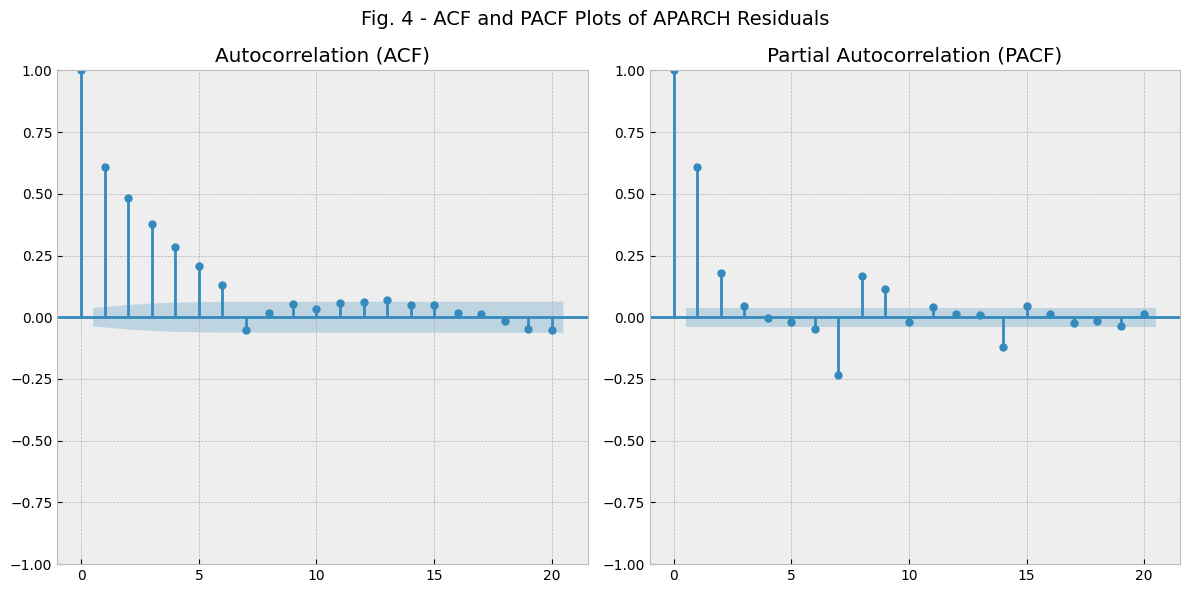

In [56]:
# Get standardized residuals
std_resid = res_aparch.resid / res_aparch.conditional_volatility
std_resid = std_resid.dropna()
acf_plot(std_resid, lags=20, figsize=(12, 6), style='bmh', title='Fig. 4 - ACF and PACF Plots of APARCH Residuals')

**Note:**

  - ** 2: Squares the residuals — this is crucial because GARCH models volatility (second moment), so here is testing for autocorrelation in the variance, not the mean.

  - Why? In GARCH model, we don't concerned with mean residual autocorrelation (as in ARIMA), but autocorrelation in the squared residuals.

  - If there is still autocorrelation in the squared residuals after fitting your model, it means the model hasn't captured the volatility clustering well.

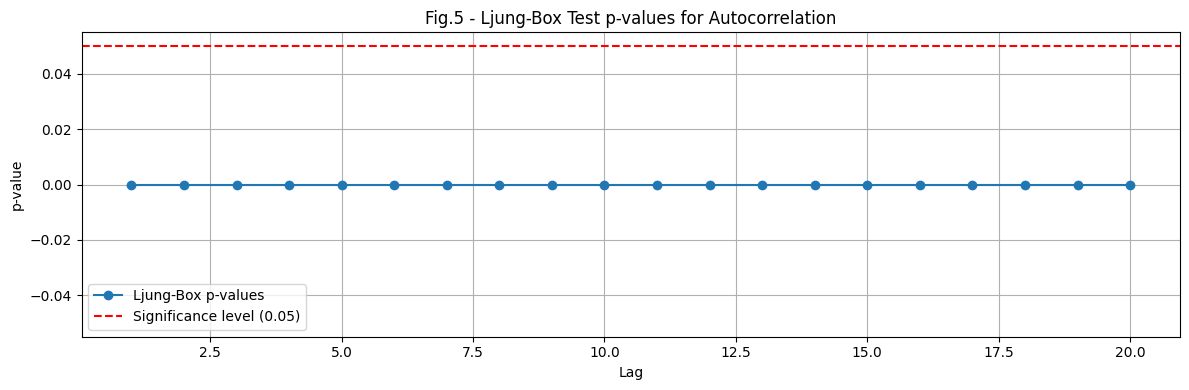

In [57]:
# Ljung-Box test
residuals = res_aparch.resid.dropna()** 2
lb_test = sm.stats.diagnostic.acorr_ljungbox(residuals, lags=20, return_df=True)

# Plot p-values with reference line at alpha = 0.05
plt.figure(figsize=(12, 4))
plt.plot(lb_test.index, lb_test['lb_pvalue'], marker='o', label='Ljung-Box p-values')
plt.axhline(y=0.05, color='r', linestyle='--', label='Significance level (0.05)')

# Labeling
plt.title('Fig.5 - Ljung-Box Test p-values for Autocorrelation')
plt.xlabel('Lag')
plt.ylabel('p-value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

From Fig.4 and Fig.5, it can be concluded that time series has a serial correlation issue.

### B. ARCH LM Test (Engle's Test)

Engle's ARCH test checks whether the squared residuals (errors) from a time series model (like ARIMA) show autocorrelation — which would indicate ARCH effects, or time-varying volatility.

**Null Hypothesis (H₀):**
There are no ARCH effects (i.e., the variance of residuals is constant over time — homoscedasticity).

**Alternative Hypothesis (H₁):**
There are ARCH effects (i.e., the variance of residuals changes over time — conditional heteroscedasticity).




In [58]:
# ARCH LM test for remaining ARCH effects
test_result = res_aparch.arch_lm_test(lags=15)
print(f"ARCH LM Test Statistic: {test_result.stat:.4f}")
print(f"p-value: {test_result.pval:.4f}")

ARCH LM Test Statistic: 1963.2094
p-value: 0.0000


If p-value < 0.05 → Reject H₀ → ARCH effects are present. The residuals exhibit volatility clustering, considering fitting a GARCH-type model.

### C. Distribution Fit of Standardized Residuals


Jarque-Bera test statistic: 711.0758291259167
p-value: 3.9070196719733804e-155


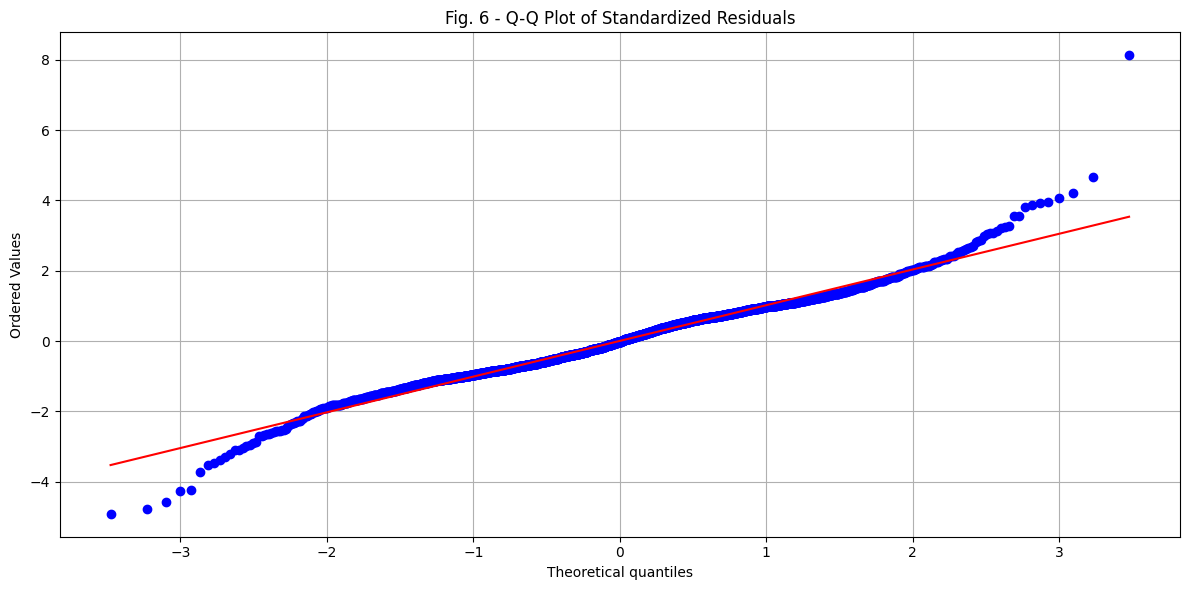

In [59]:
from scipy.stats import probplot

# ✅ Perform Jarque-Bera test on standardized residuals
jb_stat, jb_pvalue,_,_ = jarque_bera(std_resid)
print("Jarque-Bera test statistic:", jb_stat)
print("p-value:", jb_pvalue)

# ✅ Q-Q plot for checking normality of standardized residuals
plt.figure(figsize=(12, 6))
probplot(std_resid, dist="norm", plot=plt)  # Use std_resid here for correct normality check

# ✅ Add grid and title
plt.grid(True)
plt.title("Fig. 6 - Q-Q Plot of Standardized Residuals")

# ✅ Show plot
plt.tight_layout()
plt.show()

The test statistic shows that p-value < 0.05, so can reject the null hypothesis. Additionally, the Q-Q Plot also indicates that residuals doesn't seem to be normally distributed.

### D. Conditional Volatility Plot

**Conditional Volatility**

  - So, the model predicts how “bumpy” the market will be right now, based on the recent past — it’s conditional on recent info.

  - In the plot, conditional volatility shows how the model estimates the changing risk or uncertainty over time.

**Standardized Residuals**

  - When the model tries to explain the data, it has some errors or “leftover parts” it couldn’t predict perfectly — these are called residuals.

  - In simple terms, standardized residuals are the “surprise parts” of the data once we account for how bumpy or volatile the market was predicted to be.

  - Good sign: Residuals fluctuate randomly around zero without obvious trends or clusters.





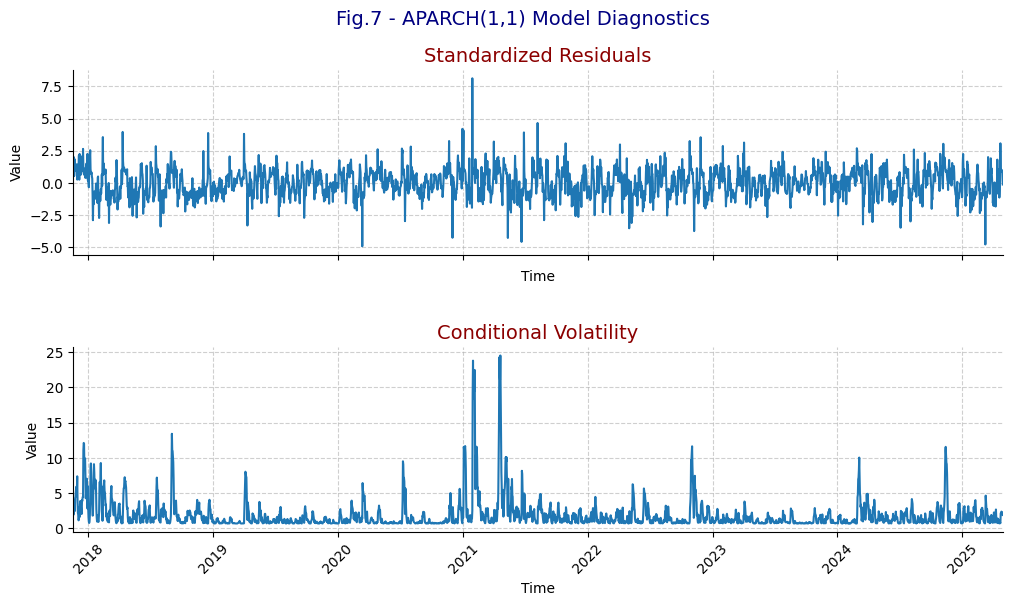

In [60]:
# Generate and customize the figure at once
fig = res_aparch.plot()
fig.set_size_inches(12, 6)

# Main figure title
fig.suptitle('Fig.7 - APARCH(1,1) Model Diagnostics', fontsize=14, color='navy')

# Adjust layout: Add space between subplots
fig.subplots_adjust(hspace=0.5)  # increase space between rows

# Customize all subplots
for ax in fig.axes:
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_facecolor('white')
    ax.set_xlabel('Time', fontsize=10)
    ax.set_ylabel('Value', fontsize=10)
    ax.tick_params(axis='x', rotation=45)

    # Beautify titles and spines
    ax.title.set(fontsize=14, color='darkred')
    ax.spines[['top', 'right']].set_visible(False)

plt.show()


## **4. Volatility Forecasting**

Note: https://arch.readthedocs.io/en/stable/univariate/univariate_volatility_forecasting.html

In [64]:
def fix_forecast_index(forecast_df):
    """Shift forecast index by 1 day to reflect the actual forecast date (assuming daily data)."""
    fixed_df = forecast_df.copy()
    fixed_df.index = fixed_df.index + pd.Timedelta(days=1)
    return fixed_df

def print_forecast_components(forecasts, n=3):
    """Print last n rows of key forecast components from APARCH model with fixed index."""
    mean_fixed = fix_forecast_index(forecasts.mean)
    resid_var_fixed = fix_forecast_index(forecasts.residual_variance)
    total_var_fixed = fix_forecast_index(forecasts.variance)

    print("📈 Forecasted Conditional Mean (last {}):".format(n))
    print(mean_fixed.iloc[-n:])

    print("\n📊 Forecasted Residual Variance (last {}):".format(n))
    print(resid_var_fixed.iloc[-n:])

    print("\n🔍 Forecasted Total Conditional Variance (last {}):".format(n))
    print(total_var_fixed.iloc[-n:])

# Generate forecasts from the fitted APARCH model
forecasts = res_aparch.forecast()

# Print the last 3 forecast points with corrected forecast dates
print_forecast_components(forecasts, n=3)

📈 Forecasted Conditional Mean (last 3):
                 h.1
Date                
2025-04-30 -0.105007

📊 Forecasted Residual Variance (last 3):
                 h.1
Date                
2025-04-30  1.116713

🔍 Forecasted Total Conditional Variance (last 3):
                 h.1
Date                
2025-04-30  1.116713


**Fixed Window Forecasting**

In [69]:
res = aparch.fit(last_obs="2024-12-31", update_freq=5)
forecasts = res.forecast(horizon=5, method='simulation', simulations=1000)

print(forecasts.variance.dropna().head())

Iteration:      5,   Func. Count:     40,   Neg. LLF: 13205.097730722042
Iteration:     10,   Func. Count:     74,   Neg. LLF: 84191.05471446377
Iteration:     15,   Func. Count:    108,   Neg. LLF: 4646.760217984833
Iteration:     20,   Func. Count:    139,   Neg. LLF: 4629.257309529112
Iteration:     25,   Func. Count:    169,   Neg. LLF: 4629.072516049404
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4629.072516049404
            Iterations: 26
            Function evaluations: 174
            Gradient evaluations: 26
                 h.1       h.2       h.3       h.4        h.5
Date                                                         
2024-12-30  0.533472  0.843984  1.087148  1.399138   1.804060
2024-12-31  0.889615  1.171333  1.420817  1.808221   2.126640
2025-01-01  0.585670  0.871330  1.186633  1.438563   1.555341
2025-01-02  1.657028  2.088303  2.377696  2.494223   2.586843
2025-01-03  7.891260  8.470566  9.025605  9.665859  13.73

In [77]:
# Make sure to align indices properly
actual_var = target.loc[forecasts.variance.index].abs()

# Extract 1-step ahead forecasted variance ('h.1')
forecast_var_1h = forecasts.variance['h.1']

# Align both series
actual_var, forecast_var_1h = actual_var.align(forecast_var_1h, join='inner')

# Calculate metrics
mae = mean_absolute_error(actual_var, forecast_var_1h)
mse = mean_squared_error(actual_var, forecast_var_1h)
rmse = np.sqrt(mse)
r2 = r2_score(actual_var, forecast_var_1h)

print(f"1-step ahead Forecast Metrics:")
print(f"MAE: {mae:.6f}")
print(f"MSE: {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"R²: {r2:.6f}")

1-step ahead Forecast Metrics:
MAE: 3.415843
MSE: 24.804768
RMSE: 4.980439
R²: -231108.134238


**Rolling Window Forecasting**

In [78]:
# Define initial training size
train_size = int(len(target) * 0.8)
train, test = target[:train_size], target[train_size:]

# Store 1-step ahead volatility forecasts
vol_forecasts = []

# Expanding window forecast loop
for i in range(len(test)):
    train_expanding = target[:train_size + i]

    # Fit EGARCH(1,1) on expanding training set
    model = arch_model(train_expanding, mean='Constant', p=1, o=0, q=1, dist='normal', vol='APARCH', rescale=True)
    res = model.fit(disp='off')

    # Get 1-step ahead forecast of conditional variance
    forecast = res.forecast(horizon=1)
    variance = forecast.variance.iloc[-1, 0]  # 1-step ahead variance
    vol_forecasts.append(np.sqrt(variance))  # Convert to standard deviation (volatility)

# Create Series aligned with test data
vol_forecast_series = pd.Series(vol_forecasts, index=test.index)

# Evaluate: compare forecasted volatility with actual absolute returns
actual_vol_proxy = test.abs()  # rough proxy for realized volatility

mae = mean_absolute_error(actual_vol_proxy, vol_forecast_series)
mse = mean_squared_error(actual_vol_proxy, vol_forecast_series)
r2 = r2_score(actual_vol_proxy, vol_forecast_series)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R^2: {r2:.4f}")

MAE: 1.6730
MSE: 4.8022
R^2: -20021.1163
